# Assignment 5
### Part 0: Libraries

In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from sklearn.mixture import GaussianMixture

### Part 1: Forming dataset

In [3]:
transactions = pd.read_csv('anonymized.csv')
transactions.head()

,Date,Amount
0,25May2016,54241.35
1,29May2017,54008.83
2,30Jun2017,54008.82
3,05Jan2017,52704.37
4,23Feb2017,52704.36


In [4]:
dates = list(map(lambda date: datetime.strptime(date, '%d%b%Y'), transactions['Date']))

In [5]:
years = pd.Series(list(map(lambda date: date.year, dates)))
months = pd.Series(list(map(lambda date: date.month, dates)))
days = pd.Series(list(map(lambda date: date.day, dates)))

In [6]:
years.name = 'Year'
months.name = 'Month'
days.name = 'Day'
transactions = pd.concat([transactions, years, months, days], axis=1)

In [7]:
transactions.head()

,Date,Amount,Year,Month,Day
0,25May2016,54241.35,2016,5,25
1,29May2017,54008.83,2017,5,29
2,30Jun2017,54008.82,2017,6,30
3,05Jan2017,52704.37,2017,1,5
4,23Feb2017,52704.36,2017,2,23


### Part 2: Defining Gaussian mixture plotting function
Below I define a GMM with independent mixtures (no covariance) since we have only 1 dimension.

In [221]:
def gmm_calc(weights, means, covs, rng=[0, 120]):
    x = np.linspace(rng[0], rng[1], 200)
    y = np.zeros((len(x), 1))
    
    for i in range(len(means)):
        exp = np.exp(-(x - means[i])**2 / (2*covs[i]**2)).reshape(-1, 1)
        y += weights[i] / np.sqrt(2*np.pi*covs[i]) * exp # update mixture
    
    return x, y

def gmm_plot(x, y, orig_distr):
    plt.figure(figsize=(10, 6), dpi=330)
    plt.hist(orig_distr, density=True) # rescale original freq to probabilities
    plt.plot(x, y)
    plt.show()

### Task 3: Density model for the number of transactions that occur in a single month

In [ ]:
task3 = transactions.sort_values(by=['Year', 'Month'])
trans_in_month = []
cur = -1
count = 0

for i in task3.index:
    if task3.loc[i, 'Month'] != cur:
        if cur != -1: # not first iteration
            trans_in_month.append(count)
        cur = task3.loc[i, 'Month']
        count = 0
    count += 1

For `n_components` from 1 to 3, the GMM seemed to be too "flat" and does not capture the bumps we have at $10$ and $58$. For `n_components` from 5 upwards, the GMM overfits and creates patterns that do not seem likely in real life (e.g., too many spikes). More formally, we can look at model likelihood and evaluate its tradeoff with the "weird curviness."

In reality, it looks like a mixture of 2 Gaussians with weights of about $0.3$ and $0.7$ would work well here because there are two humps but for some reason I was not able to fit properly when `n_components=2`.

In [376]:
mm3 = GaussianMixture(n_components=4)
mm3.fit(np.array(trans_in_month).reshape(-1, 1))
print("Likelihood of model:", np.e**mm3.score(np.array(trans_in_month).reshape(-1, 1)))

Likelihood of model: 0.012573904239640377


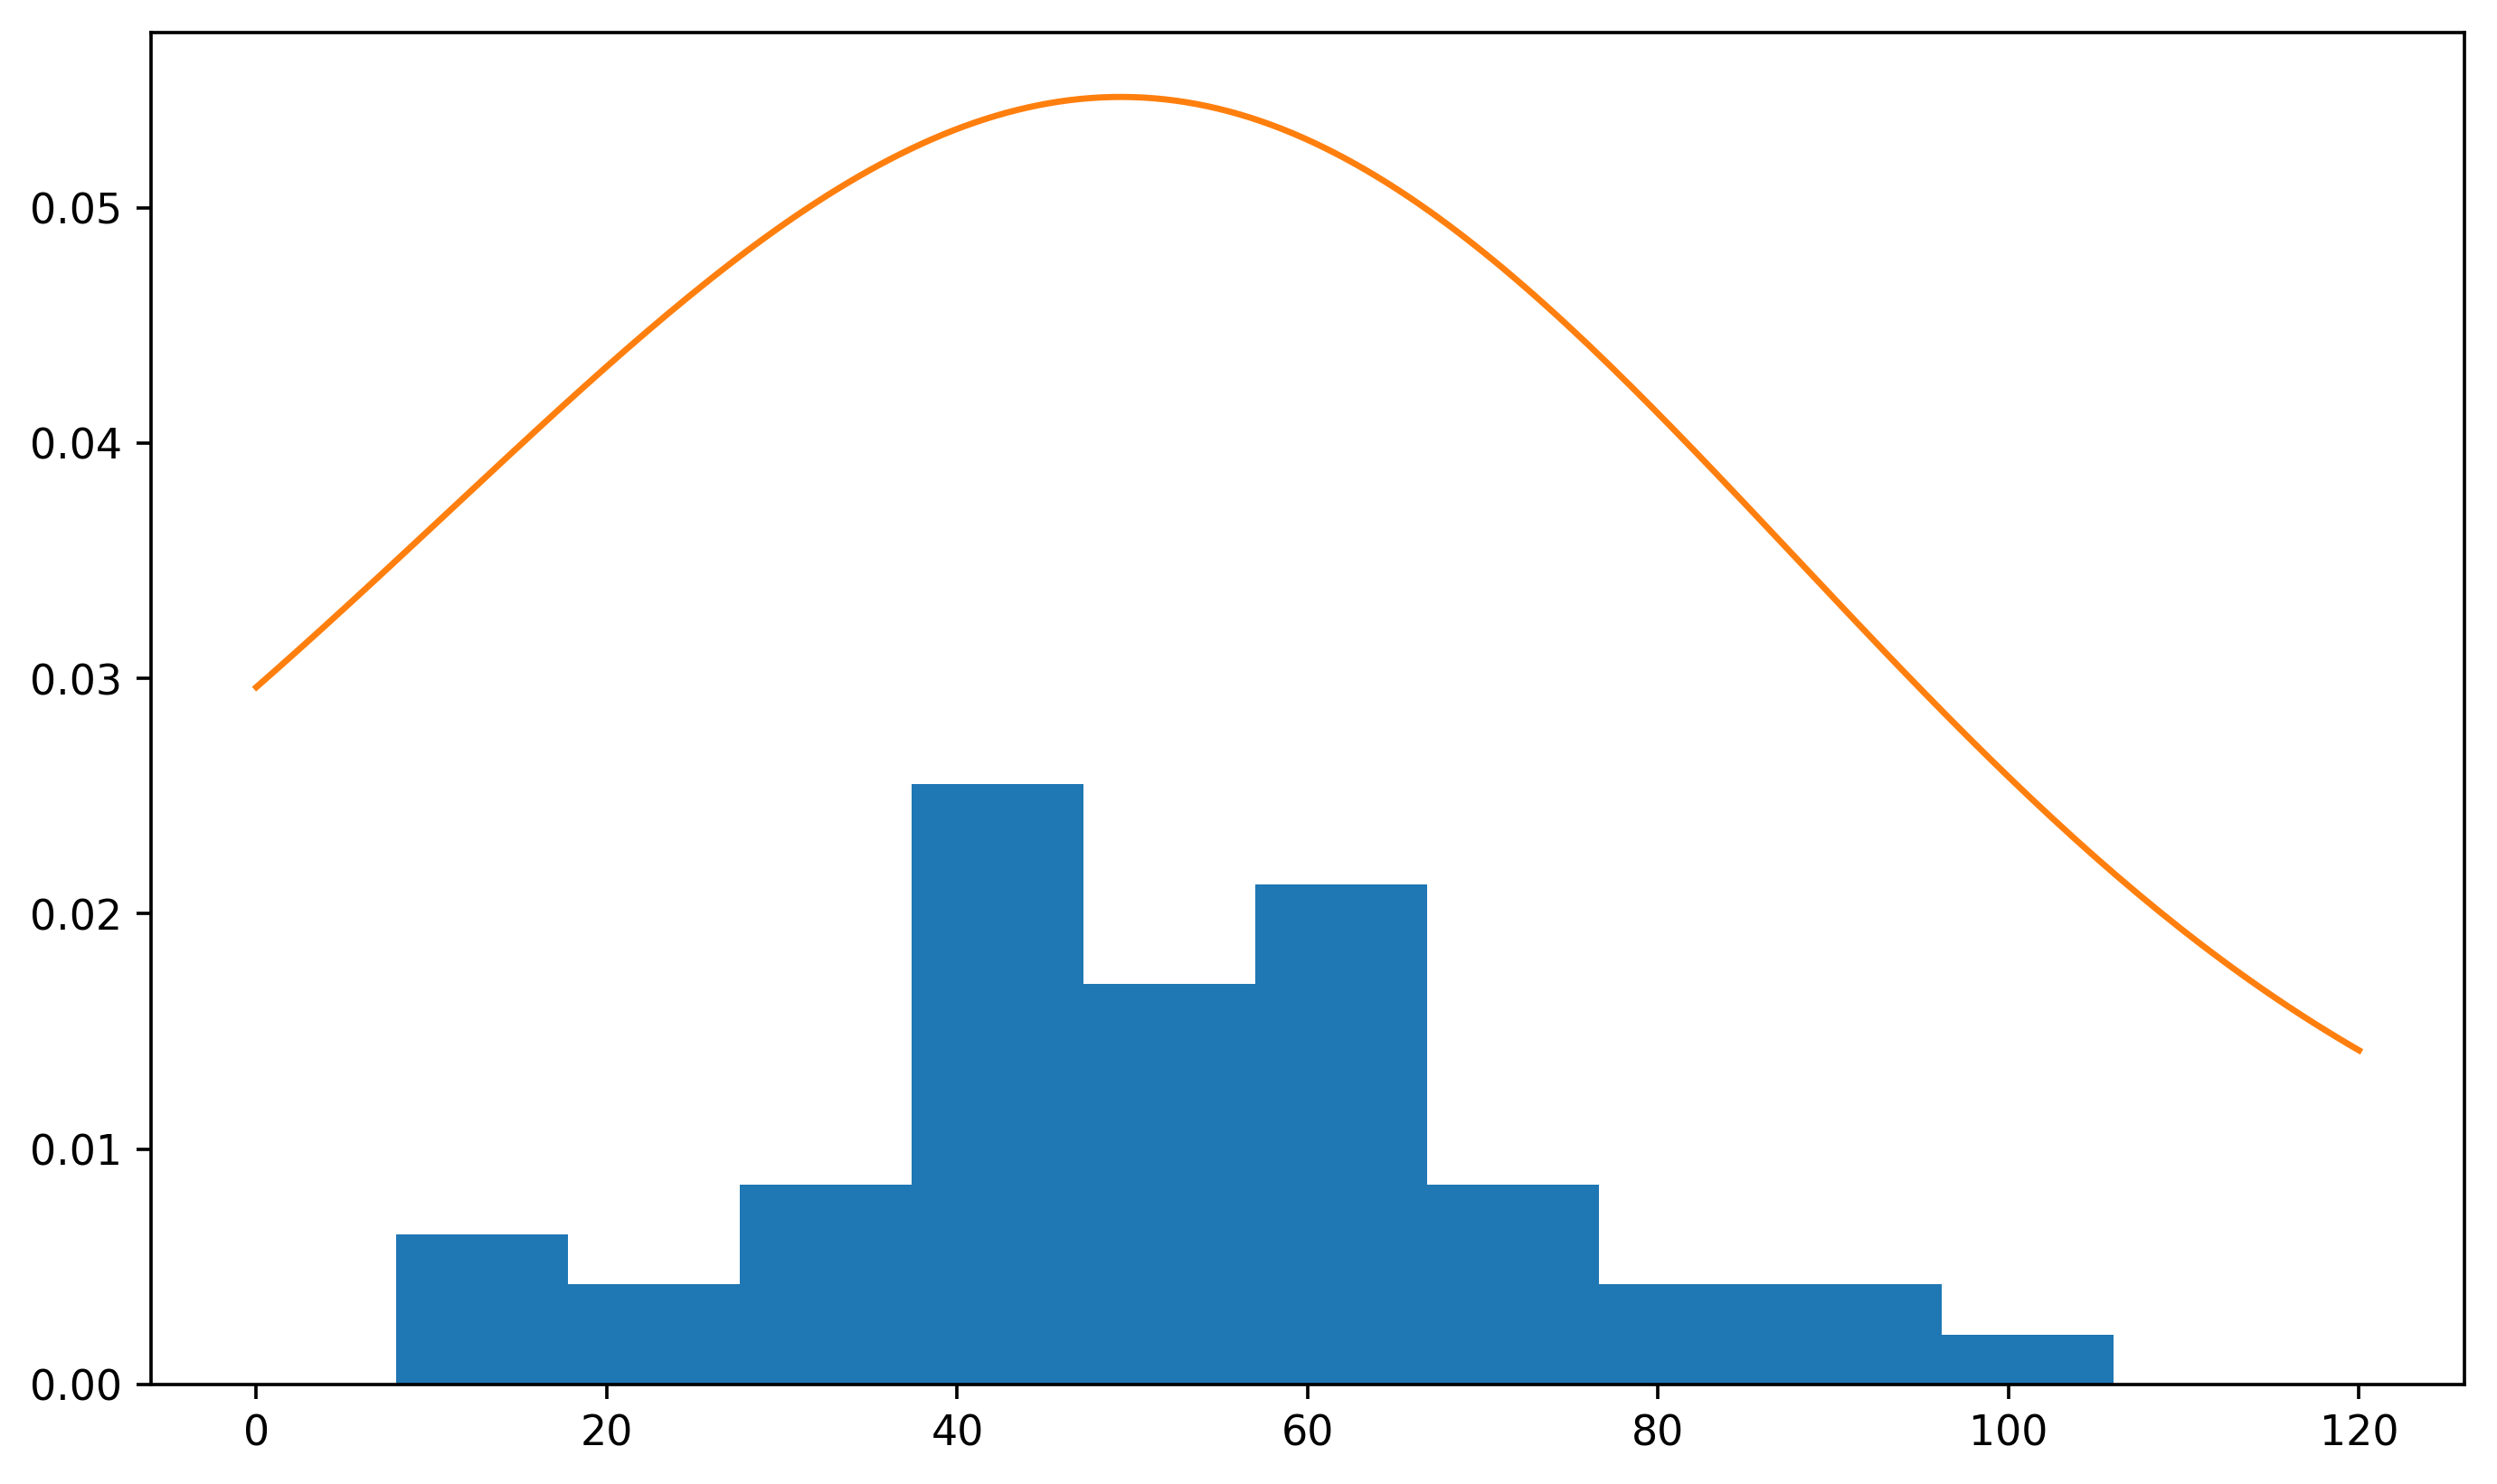

In [377]:
x, y = gmm_calc(mm3.weights_, mm3.means_.flatten(), mm3.covariances_.flatten())
gmm_plot(x, y, trans_in_month)

### Task 4: Density model for the day in the month that a transaction will occur on

In [208]:
task4 = transactions.sort_values(by=['Day'])
day_trans = [0] * 32 # 31 days (counting from 1)

for i in task4.index:
    day = task4.loc[i, 'Day']
    day_trans[day] += 1

In [215]:
day_trans_exp = [] # expanded version
for i in range(len(day_trans)):
    for j in range(day_trans[i]):
        day_trans_exp.append(i)

Again, looks like there can be two Gaussians with weights about $0.4$ and $0.6$, but it `sklearn` doesn't fit nicely :( 4 components seem to almost fit and 5 components seem to describe to contours nicely.

In [361]:
mm4 = GaussianMixture(n_components=5)
mm4.fit(np.array(day_trans_exp).reshape(-1, 1))
print("Likelihood of model:", np.e**mm4.score(np.array(day_trans_exp).reshape(-1, 1)))

Likelihood of model: 0.031803070806674986


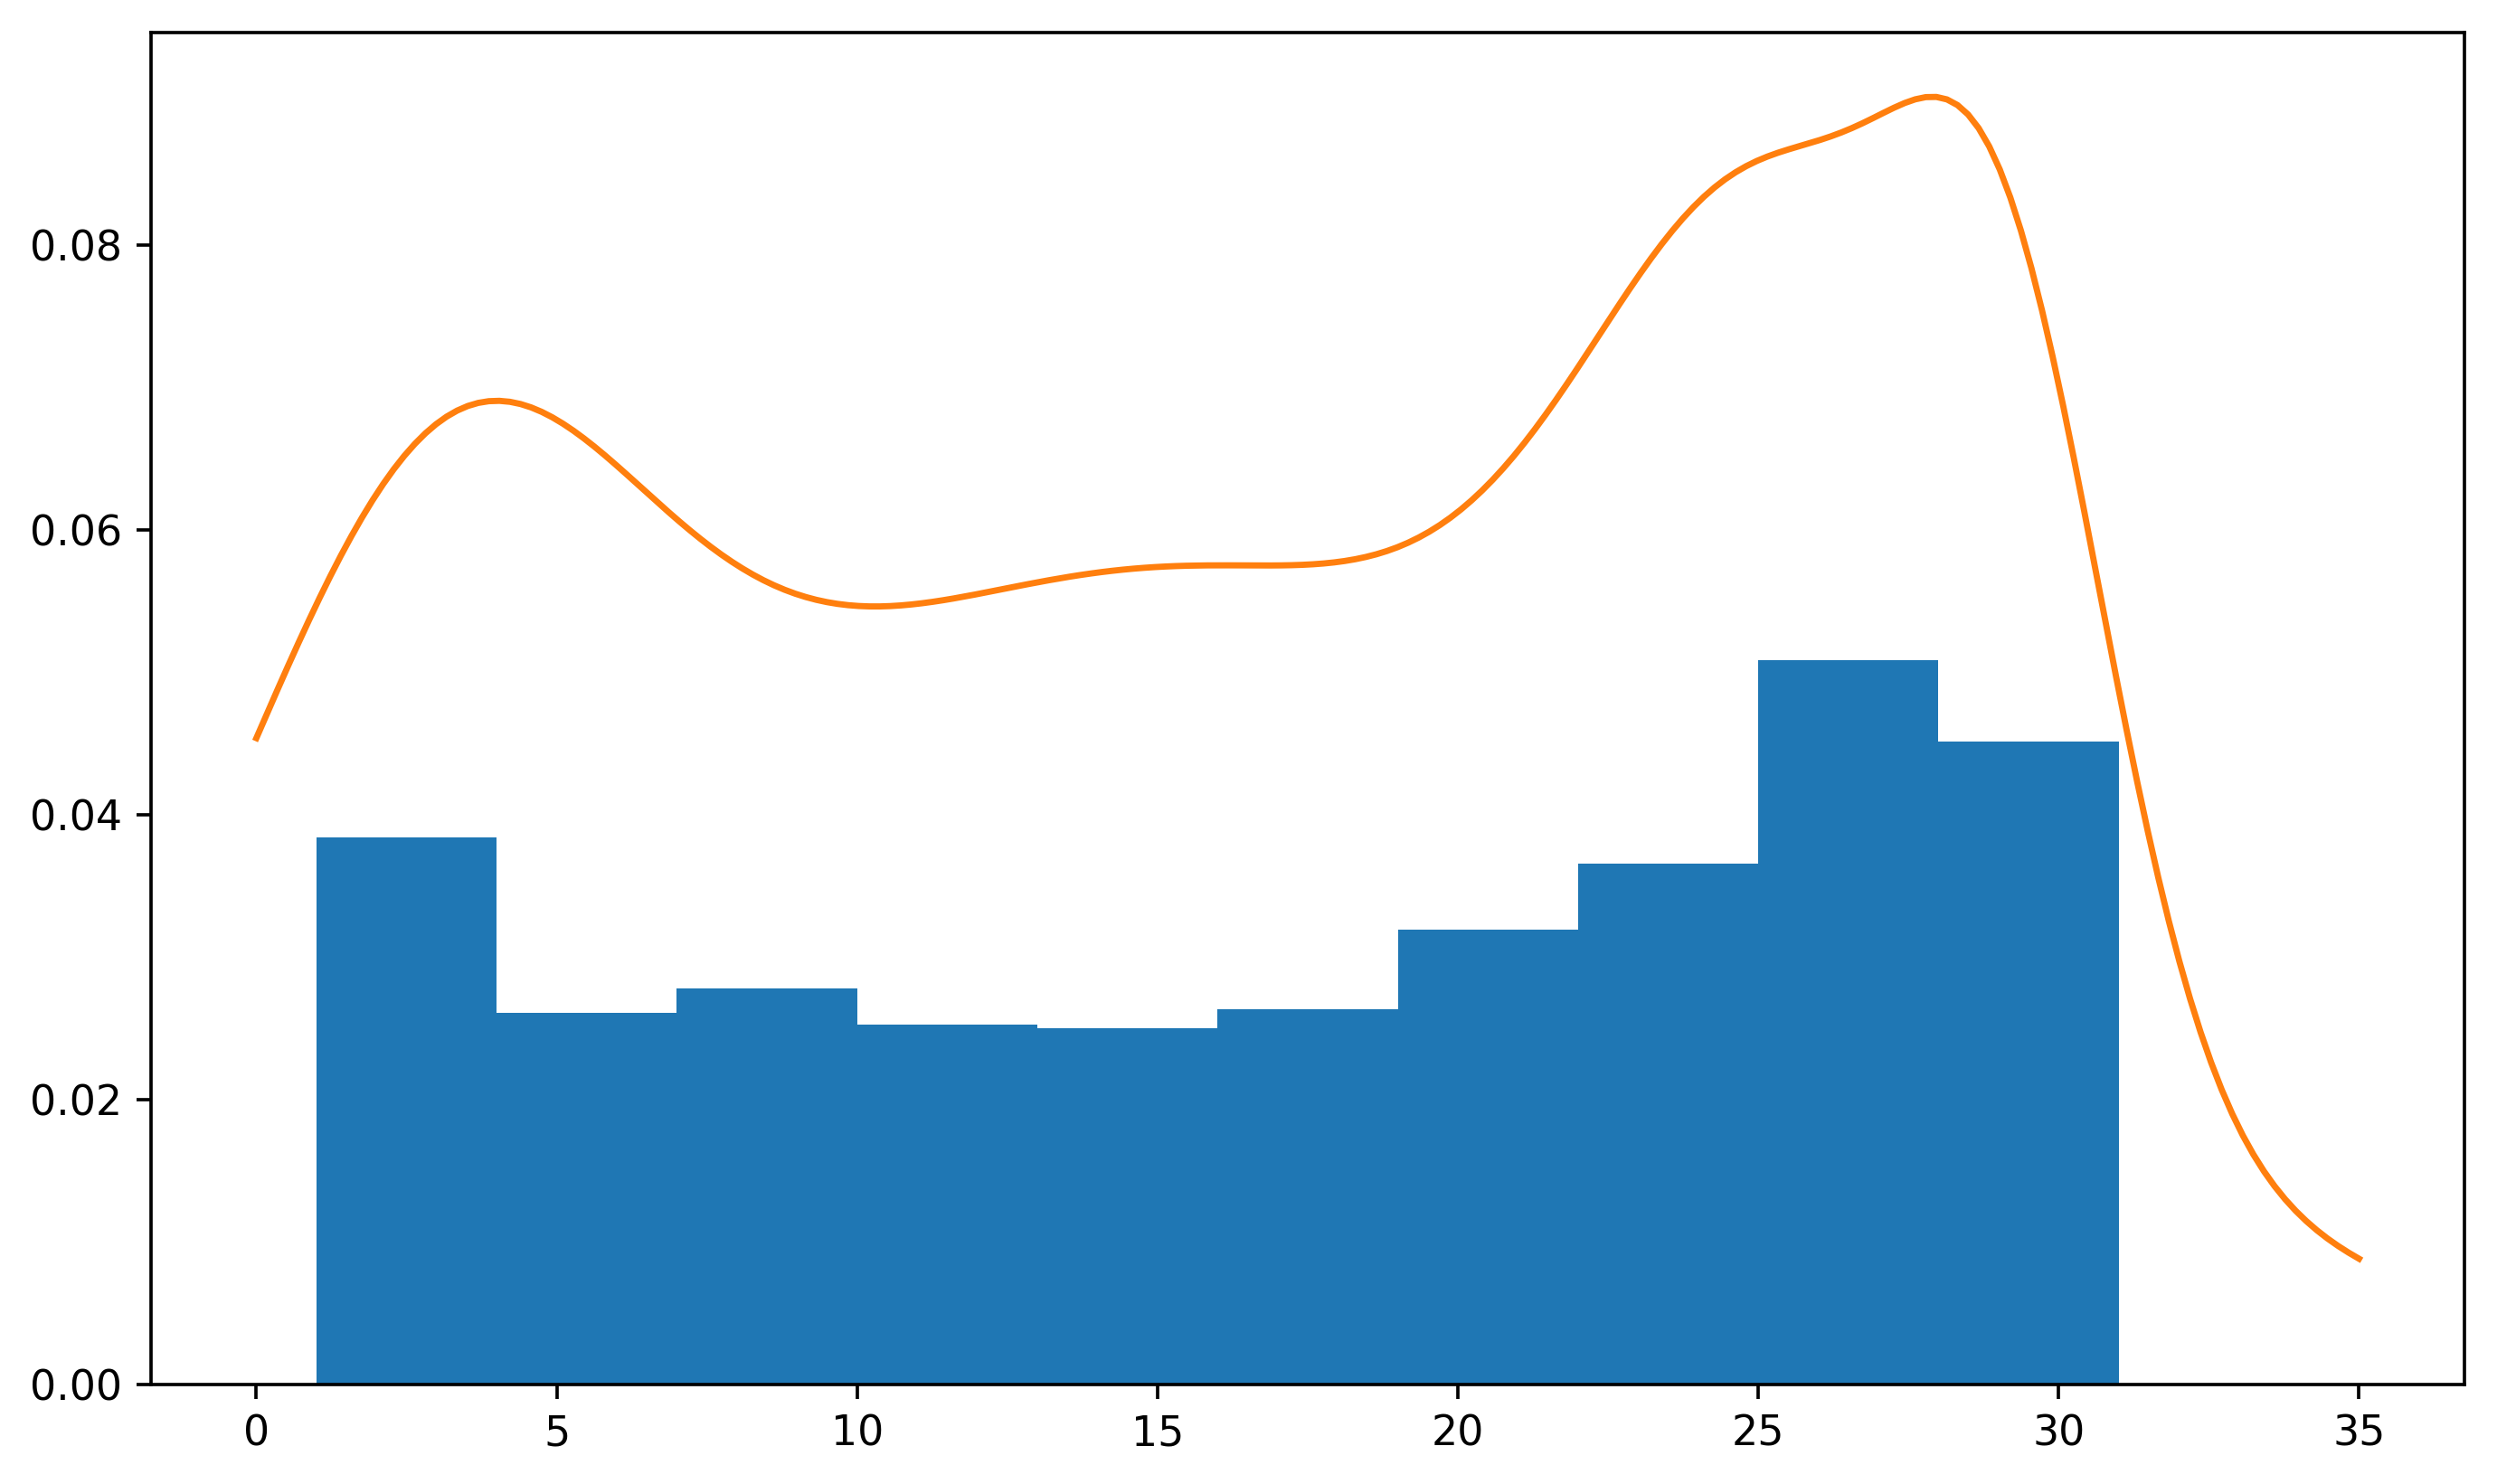

In [362]:
x4, y4 = gmm_calc(mm4.weights_, mm4.means_.flatten(), mm4.covariances_.flatten(), [0, 35])
gmm_plot(x4, y4, day_trans_exp)

### Task 5: Density model for transaction size

In [308]:
trans_size = list(transactions['Amount'])
trans_size[:5]

[54241.35, 54008.83, 54008.82, 52704.37, 52704.36]

Highest likelihood achieved at `n_components=3`.

In [400]:
mm5 = GaussianMixture(n_components=3)
mm5.fit(np.array(trans_size).reshape(-1, 1))
print("Likelihood of model:", np.e**mm5.score(np.array(trans_size).reshape(-1, 1)))

Likelihood of model: 0.00020029542840949136


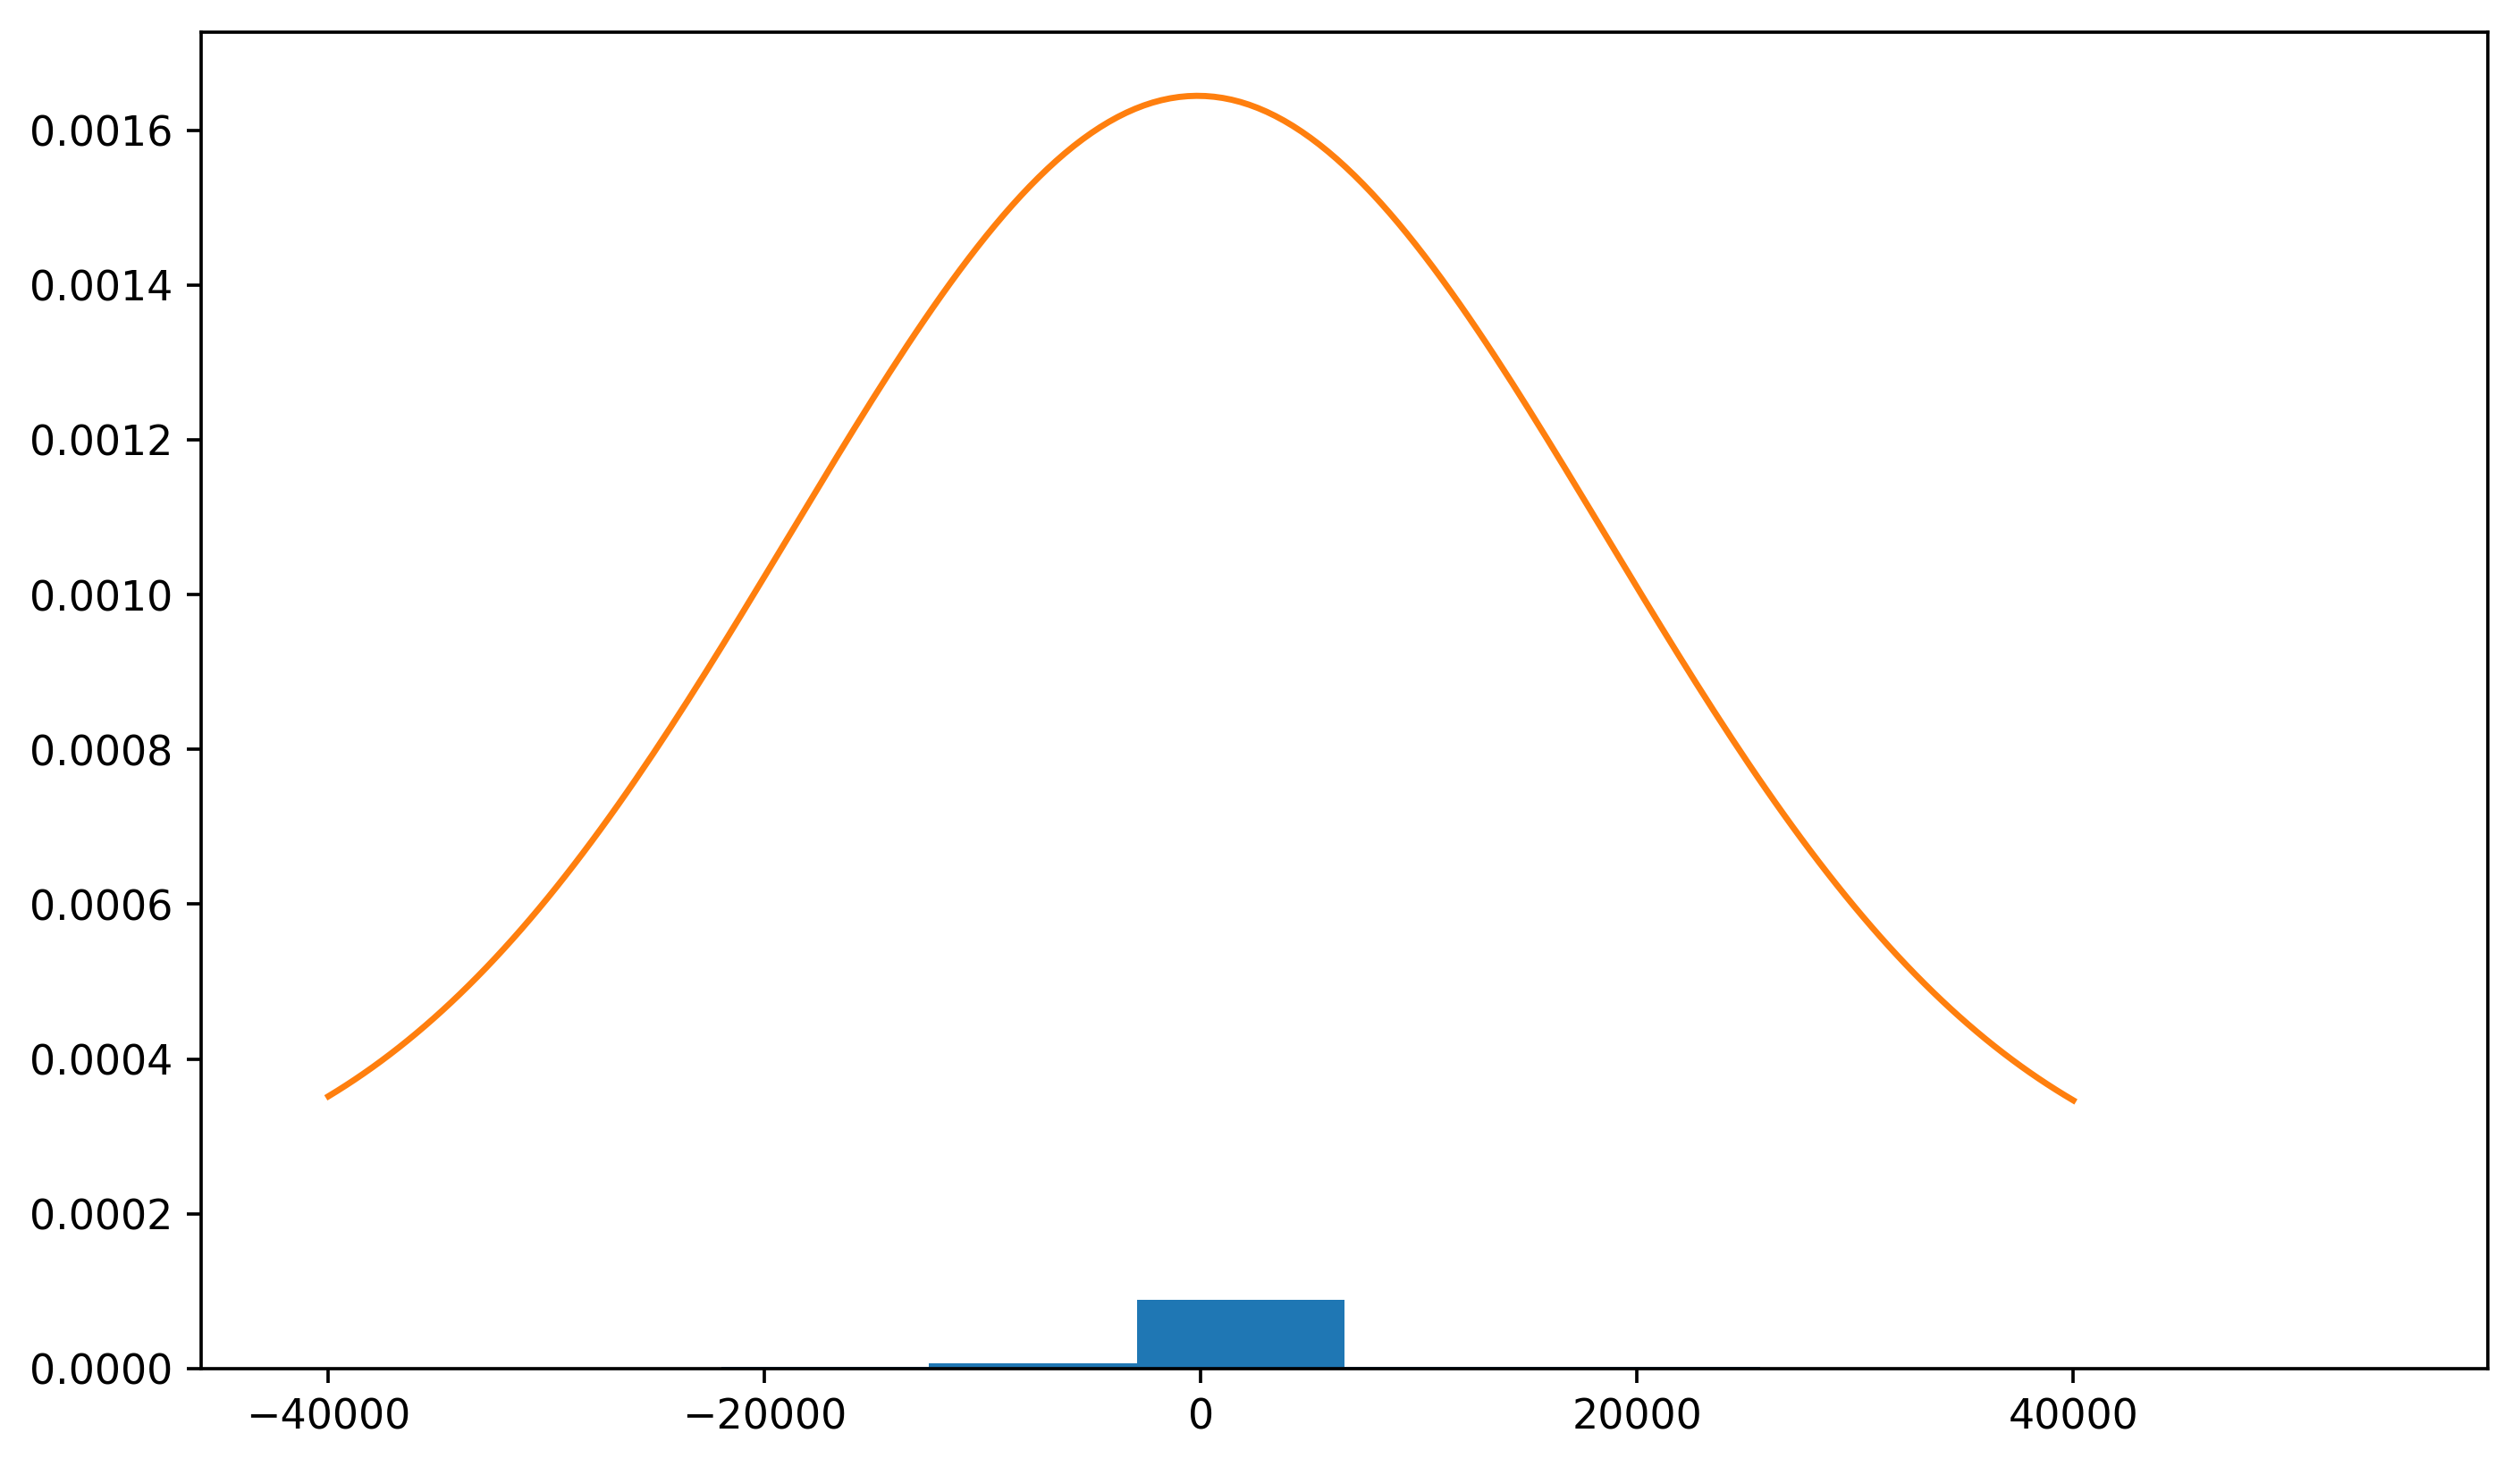

In [401]:
x5, y5 = gmm_calc(mm5.weights_, mm5.means_.flatten(), mm5.covariances_.flatten(), [-40000, 40000])
gmm_plot(x5, y5, trans_size)

### Task 6: Sample a fictious transaction month
We first draw from the number of transactions in a month distribution

In [410]:
num_of_trans = int(mm3.sample()[0][0][0])

In [416]:
# storage
fake_days = []
fake_amts = []

# draw days in which a transaction happened. Within each day, draw the amount:
for i in range(num_of_trans):
    fake_days.append(int(mm4.sample()[0][0][0]))
    fake_amts.append(int(mm5.sample()[0][0][0]))

In [420]:
fake_trans = pd.DataFrame({'Day': fake_days, 'Amount': fake_amts})
fake_trans.head()

,Day,Amount
0,24,17389
1,11,-185
2,5,-152
3,25,-87
4,19,-912


### Task 7: Explain flaws
1. On an individual level, we consider only amount of transaction without taking into account other external variables. For example, big businesses make large transactions, but there are not so many big businesses out there, thus, if another large transaction comes in, we might flag it as suspicious with our GMM even though it might not be, if it was made B2B.
2. Our dataset is only 2518 entries yet we try to extrapolate to individual months (I think there are about 12 * 4 of them), thus the distributions might not be representative of what's happening in reality. Thus, maybe we would flag transactions on day 15 with lowest probability, but it might be that in our dataset we didn't get to see day 15 as much compared to real life.
3. Another flaw would be that we don't really know what's actually suspicious. If fraudsters know about these data, they can blend in places with high probability. Then, we would lose track of them if we only look at single parameter at a time like here.